In [1]:
import torch
import os
import random
import numpy as np
import pytorch_lightning as pl

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from dataset.utils import process_classification_dataset

config = {
        'dataset': 'facebook_ct1', # 'infectious_ct1', #
        'hidden_size': 64,
        'rnn_layers': 5,
        'readout_layers': 1,
        'cell_type': 'lstm',
        'dim_red': 10,
        'add_self_loops': False,
        'verbose': True,
        'cat_states_layers': True,
        'weight_decay': 1e-3,
        'step_size': 30,
        'gamma': 0.5,
        'testing': False,
        }

# Select one GPU if more are available
os.environ["CUDA_VISIBLE_DEVICES"]='0'

seed = 42
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
pl.seed_everything(seed)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

Seed set to 42


In [2]:
dataset, states, node_states, node_labels = process_classification_dataset(config, "DynCRNN", device)

100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

inputs, test_inputs, labels, test_labels = train_test_split(states.inputs[:,-1,:], dataset.targets, test_size=0.2, random_state=seed)

# Create the classifier
classifier = LogisticRegression(max_iter=5000, random_state=seed)

# Train the classifier
classifier.fit(inputs, labels)

# Test the classifier
y_pred = classifier.predict(test_inputs)

accuracy = accuracy_score(test_labels, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 1.0


# PCA

Let's check how the two classes separate in the first three PC when doing dimensionality reduction to 10

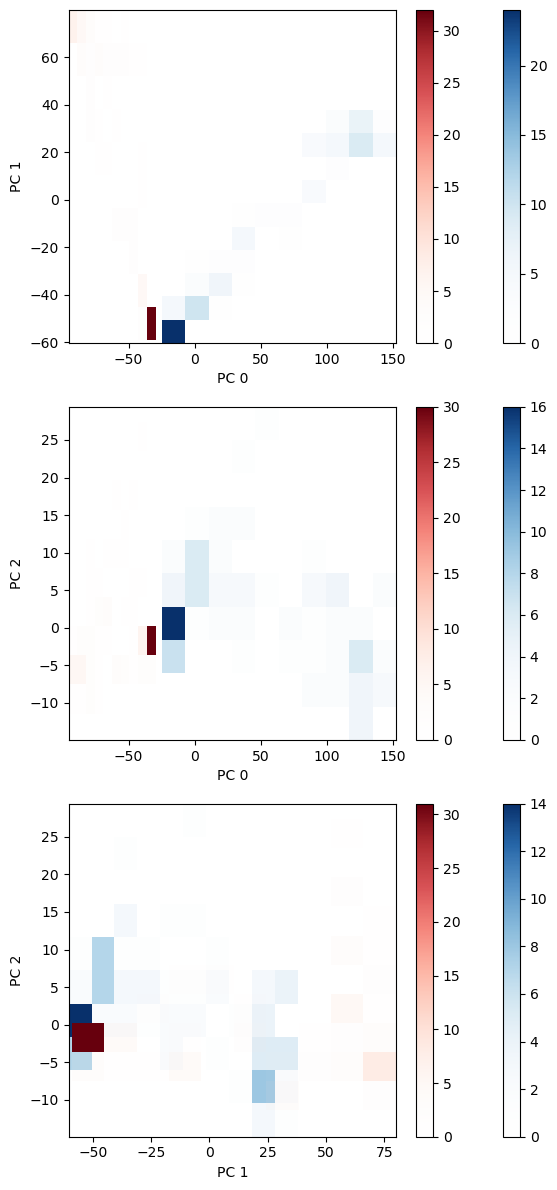

In [4]:
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA

train_X, val_X, train_y, val_y = train_test_split(states.inputs, states.targets, test_size=0.2, random_state=seed)

pca = PCA(n_components=10)
train_X_red = pca.fit_transform(train_X[:,-1,:])
val_X_red = pca.transform(val_X[:,-1,:])

idx0 = val_y == 0
idx1 = val_y == 1
label_0 = val_X_red[idx0]
label_1 = val_X_red[idx1]

# modify existing Reds colormap with a linearly fading alpha
red = pl.cm.Reds  # original colormap
fading_red = red(np.arange(red.N)) # extract colors
fading_red[:, -1] = np.linspace(0, 1, red.N) # modify alpha
fading_red = ListedColormap(fading_red) # convert to colormap

blue = pl.cm.Blues  # original colormap
fading_blue = blue(np.arange(blue.N)) # extract colors
fading_blue[:, -1] = np.linspace(0, 1, blue.N) # modify alpha
fading_blue = ListedColormap(fading_blue) # convert to colormap

# Calculate min and max values for each PC
pc0_min, pc0_max = min(val_X_red[:, 0]), max(val_X_red[:, 0])
pc1_min, pc1_max = min(val_X_red[:, 1]), max(val_X_red[:, 1])
pc2_min, pc2_max = min(val_X_red[:, 2]), max(val_X_red[:, 2])

# Create a figure with two subplots
fig, axs = plt.subplots(3, 1, figsize=(6, 12))

# PC0 vs PC1
# Plot the first histogram in the first subplot
hist1 = axs[0].hist2d(label_0[:, 0], label_0[:, 1], bins=10, cmap=fading_blue, label='Label 0')
hist2 = axs[0].hist2d(label_1[:, 0], label_1[:, 1], bins=10, cmap=fading_red, label='Label 1')
axs[0].set_xlabel('PC 0')
axs[0].set_ylabel('PC 1')
axs[0].set_xlim(pc0_min, pc0_max)
axs[0].set_ylim(pc1_min, pc1_max)
plt.colorbar(hist1[3], ax=axs[0])
plt.colorbar(hist2[3], ax=axs[0])

# PC0 vs PC2
# Plot the first histogram in the first subplot
hist3 = axs[1].hist2d(label_0[:, 0], label_0[:, 2], bins=10, cmap=fading_blue, label='Label 0')
hist4 = axs[1].hist2d(label_1[:, 0], label_1[:, 2], bins=10, cmap=fading_red, label='Label 1')
axs[1].set_xlabel('PC 0')
axs[1].set_ylabel('PC 2')
axs[1].set_xlim(pc0_min, pc0_max)
axs[1].set_ylim(pc2_min, pc2_max)
plt.colorbar(hist3[3], ax=axs[1])
plt.colorbar(hist4[3], ax=axs[1])

# PC1 vs PC2
# Plot the first histogram in the first subplot
hist5 = axs[2].hist2d(label_0[:, 1], label_0[:, 2], bins=10, cmap=fading_blue, label='Label 0')
hist6 = axs[2].hist2d(label_1[:, 1], label_1[:, 2], bins=10, cmap=fading_red, label='Label 1')
axs[2].set_xlabel('PC 1')
axs[2].set_ylabel('PC 2')
axs[2].set_xlim(pc1_min, pc1_max)
axs[2].set_ylim(pc2_min, pc2_max)
plt.colorbar(hist5[3], ax=axs[2])
plt.colorbar(hist6[3], ax=axs[2])

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [5]:
import plotly.express as px
import pandas as pd

# Create a DataFrame for label_1 and label_0 data
df_label_0 = pd.DataFrame(label_0[:,[0,1,2]], columns=['PC0', 'PC1', 'PC2'])
df_label_1 = pd.DataFrame(label_1[:,[0,1,2]], columns=['PC0', 'PC1', 'PC2'])

# Add a column to indicate the label
df_label_0['label'] = 'Label 0'
df_label_1['label'] = 'Label 1'

# Concatenate the dataframes
df = pd.concat([df_label_0, df_label_1])

# Create the 3D scatter plot
fig = px.scatter_3d(df, x='PC0', y='PC1', z='PC2', color='label')

# Show the plot
fig.show()

There is a strong separation in PC0. Is it showing a linear attractor?

Let's plot some trajectories as well

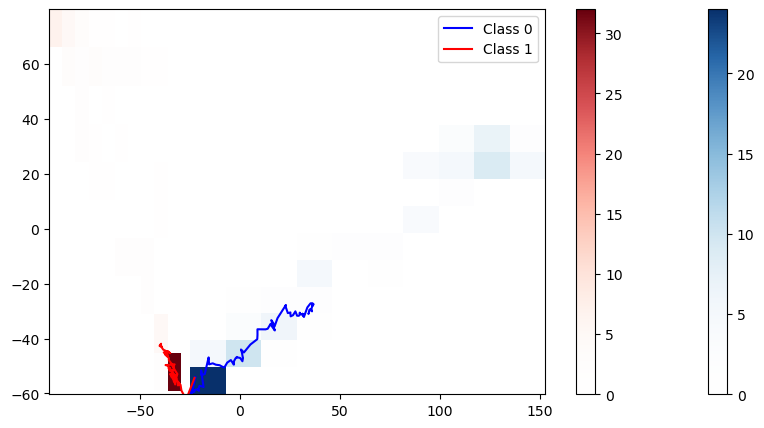

In [5]:
from einops import rearrange

val_proj20 = val_X_red[~val_y.astype(bool)]
val_proj21 = val_X_red[val_y.astype(bool)]

fig, ax = plt.subplots(figsize=(10, 5))

hist0 = ax.hist2d(val_proj20[:,0], val_proj20[:,1], bins=10, cmap=fading_blue)
hist1 = ax.hist2d(val_proj21[:,0], val_proj21[:,1], bins=10, cmap=fading_red)
ax.set_xlim(pc0_min, pc0_max)
ax.set_ylim(pc1_min, pc1_max)

plt.colorbar(hist0[3], ax=ax)
plt.colorbar(hist1[3], ax=ax)

# add one full trajectory for each class
val_X_rearr = rearrange(val_X, 'b t f -> (b t) f')
val_X_redt = pca.transform(val_X_rearr)
val_X_redt = rearrange(val_X_redt, '(b t) f -> b t f', b = val_X.shape[0], t=val_X.shape[1], f=10)

traj0 = val_X_redt[1]
traj1 = val_X_redt[0]

ax.plot(traj0[:,0], traj0[:,1], c='blue', label='Class 0')
ax.plot(traj1[:,0], traj1[:,1], c='red', label='Class 1')

# Show the plot
plt.legend()
plt.show()

Average trajectories:

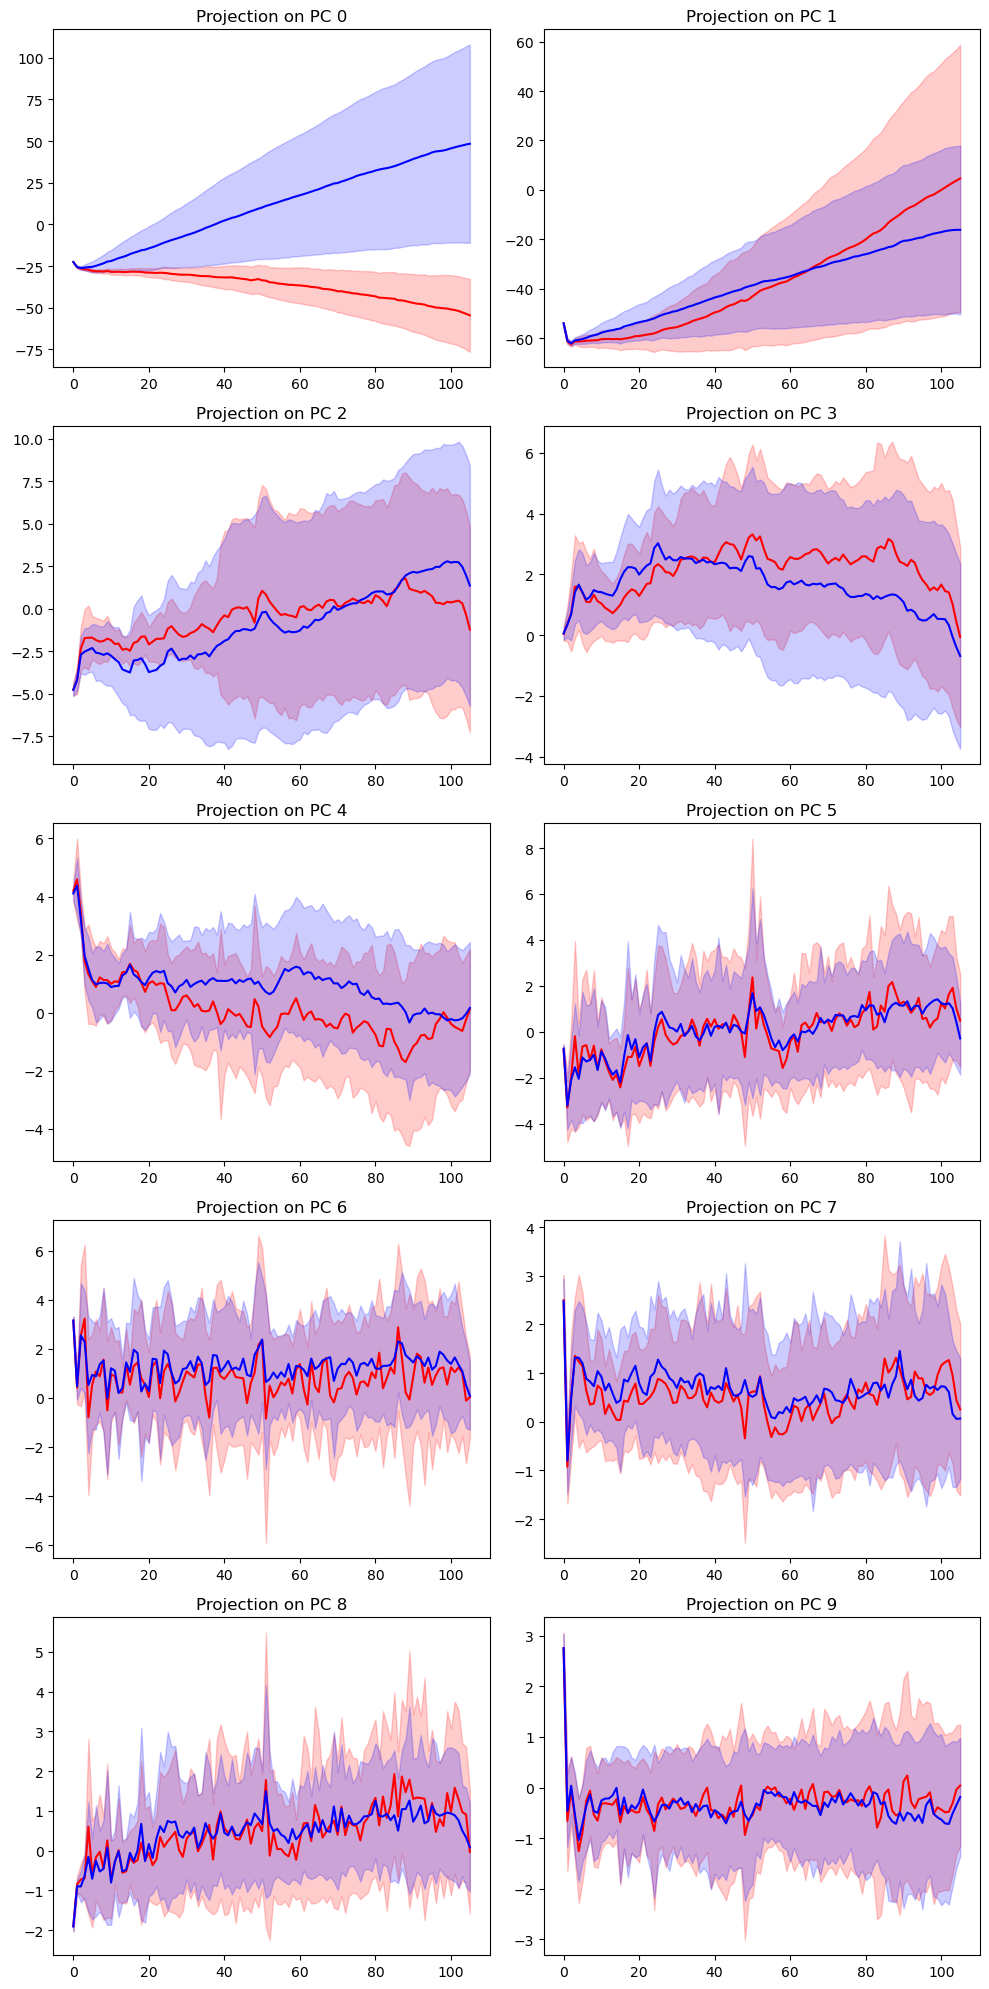

In [7]:
fig, axs = plt.subplots(5, 2, figsize=(10, 20))

for i in range(10):
    val_proj = val_X_redt[:,:,i]

    m = val_proj[val_y.astype(bool)].mean(axis=0)
    s = val_proj[val_y.astype(bool)].std(axis=0)
    m_not = val_proj[~val_y.astype(bool)].mean(axis=0)
    s_not = val_proj[~val_y.astype(bool)].std(axis=0)

    axs[i//2, i%2].plot(m, c='r', label="class 1")
    axs[i//2, i%2].fill_between(np.arange(m.shape[0]), m-s, m+s, color='r', alpha=0.2)
    axs[i//2, i%2].plot(m_not, c='b', label="class 0")
    axs[i//2, i%2].fill_between(np.arange(m.shape[0]), m_not-s_not, m_not+s_not, color='b', alpha=0.2)
    axs[i//2, i%2].set_title(f'Projection on PC {i}')

    # axs[i//2, i%2].set_ylim(-10,10)


# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

# DMD

In [6]:
from koopman.dmd import DMD

dim_red = 10
method = 'PCA'

# compute local Koopman operator
dmd = DMD(train_X, k=dim_red, emb=method)

K0 = dmd.compute_KOP()

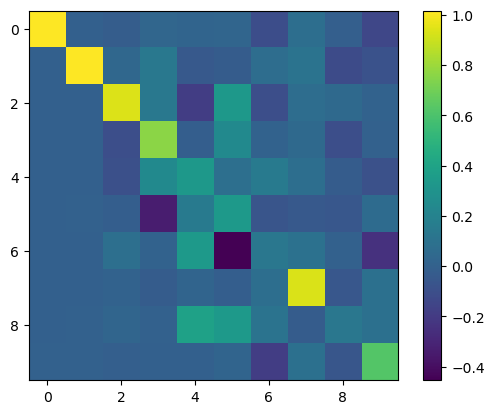

In [9]:
plt.imshow(K0)
plt.colorbar()

C:\Users\mgphy\AppData\Local\Temp\ipykernel_14332\1226691090.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


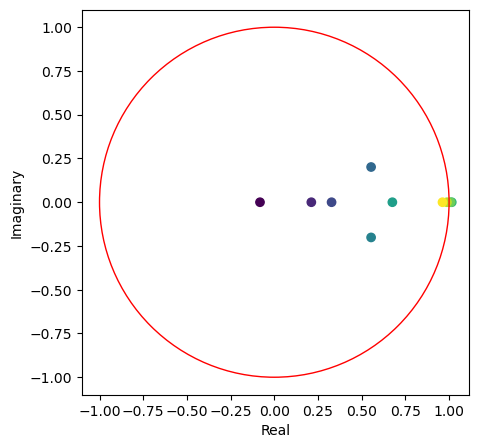

In [7]:
E, V = np.linalg.eig(K0)

# sort eigenvalues and eigenvectors
idx = np.argsort(np.abs(E))[::-1]
E = E[idx]
V = V[:, idx]

cmap = plt.cm.get_cmap('viridis')

plt.figure(figsize=(5,5))
plt.scatter(E.real, E.imag, c=idx, cmap=cmap)
circle = plt.Circle((0, 0), 1, color='r', fill=False)
plt.gca().add_patch(circle)
plt.ylabel('Imaginary') 
plt.xlabel('Real')
plt.show()

In [20]:
E

array([ 1.0155848 +0.j        ,  1.0079238 +0.j        ,
        0.9882818 +0.j        ,  0.96233225+0.j        ,
        0.67559016+0.j        ,  0.55391806-0.20121753j,
        0.55391806+0.20121753j,  0.32767493+0.j        ,
        0.21193367+0.j        , -0.08180273+0.j        ], dtype=complex64)

In [21]:
abs(E)

array([1.0155848 , 1.0079238 , 0.9882818 , 0.96233225, 0.67559016,
       0.5893333 , 0.5893333 , 0.32767493, 0.21193367, 0.08180273],
      dtype=float32)

Project states on first two eigenvectors (they are real)

In [8]:
v12 = V[:,0:2].real

# Calculate the projection
val_X_red2 = dmd.emb_engine.transform(val_X_rearr)
val_X_red2 = rearrange(val_X_red2, '(b t) f -> b t f', b = val_X.shape[0], t=val_X.shape[1], f=dim_red)
val_X_proj = np.dot(val_X_red2, v12)

In [23]:
val_X_proj.shape

(199, 106, 2)

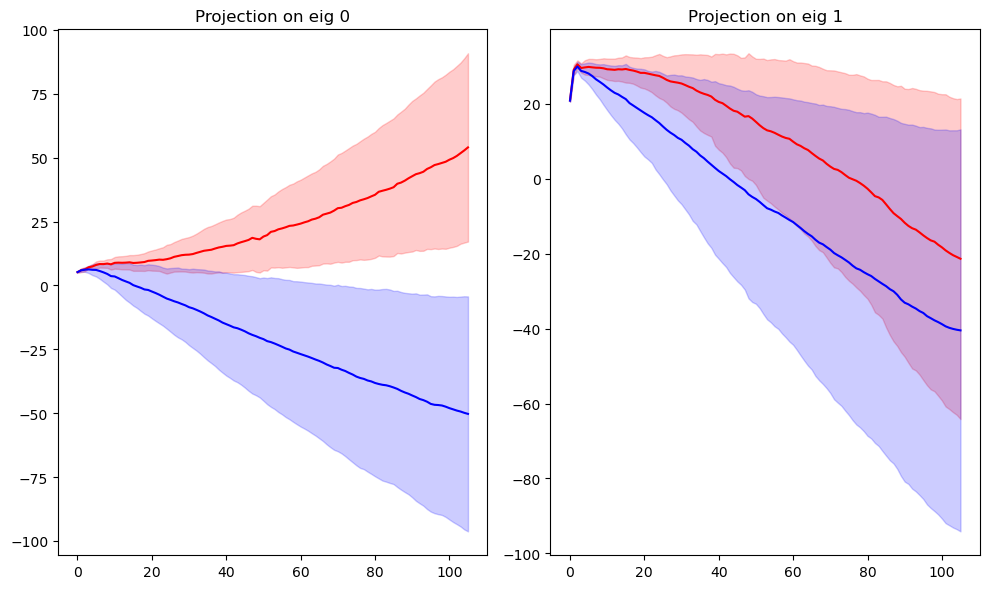

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

for i in range(2):
    val_proj = val_X_proj[:,:,i]

    m = val_proj[val_y.astype(bool)].mean(axis=0)
    s = val_proj[val_y.astype(bool)].std(axis=0)
    m_not = val_proj[~val_y.astype(bool)].mean(axis=0)
    s_not = val_proj[~val_y.astype(bool)].std(axis=0)

    axs[i%2].plot(m, c='r', label="class 1")
    axs[i%2].fill_between(np.arange(m.shape[0]), m-s, m+s, color='r', alpha=0.2)
    axs[i%2].plot(m_not, c='b', label="class 0")
    axs[i%2].fill_between(np.arange(m.shape[0]), m_not-s_not, m_not+s_not, color='b', alpha=0.2)
    axs[i%2].set_title(f'Projection on eig {i}')

    # axs[i//2, i%2].set_ylim(-10,10)


# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [21]:
v12

array([[-0.08478115, -0.01240422],
       [ 0.0290284 ,  0.2754092 ],
       [ 0.25890476,  0.7741073 ],
       [-0.03572986, -0.34988797],
       [-0.49956453,  0.41502035],
       [ 0.26238146,  0.09453747],
       [-0.7740483 , -0.11792774],
       [-0.02878   , -0.0650612 ],
       [-0.03925996, -0.05267242],
       [ 0.06109021, -0.01544988]], dtype=float32)

In [22]:
val_X.shape

(199, 106, 256)

In [23]:
val_X_red2.shape

(199, 106, 10)

Focus on two trajectories pushed forward in time with the Koopman operator

In [25]:
val_X_rec0 = np.empty_like(val_X_red2[0])
val_X_rec1 = np.empty_like(val_X_red2[1])

for n in range(val_X_red2.shape[1]):
    val_X_rec0[n] = np.dot(val_X_red2[0][0], K0**n)
    val_X_rec1[n] = np.dot(val_X_red2[1][0], K0**n)
    

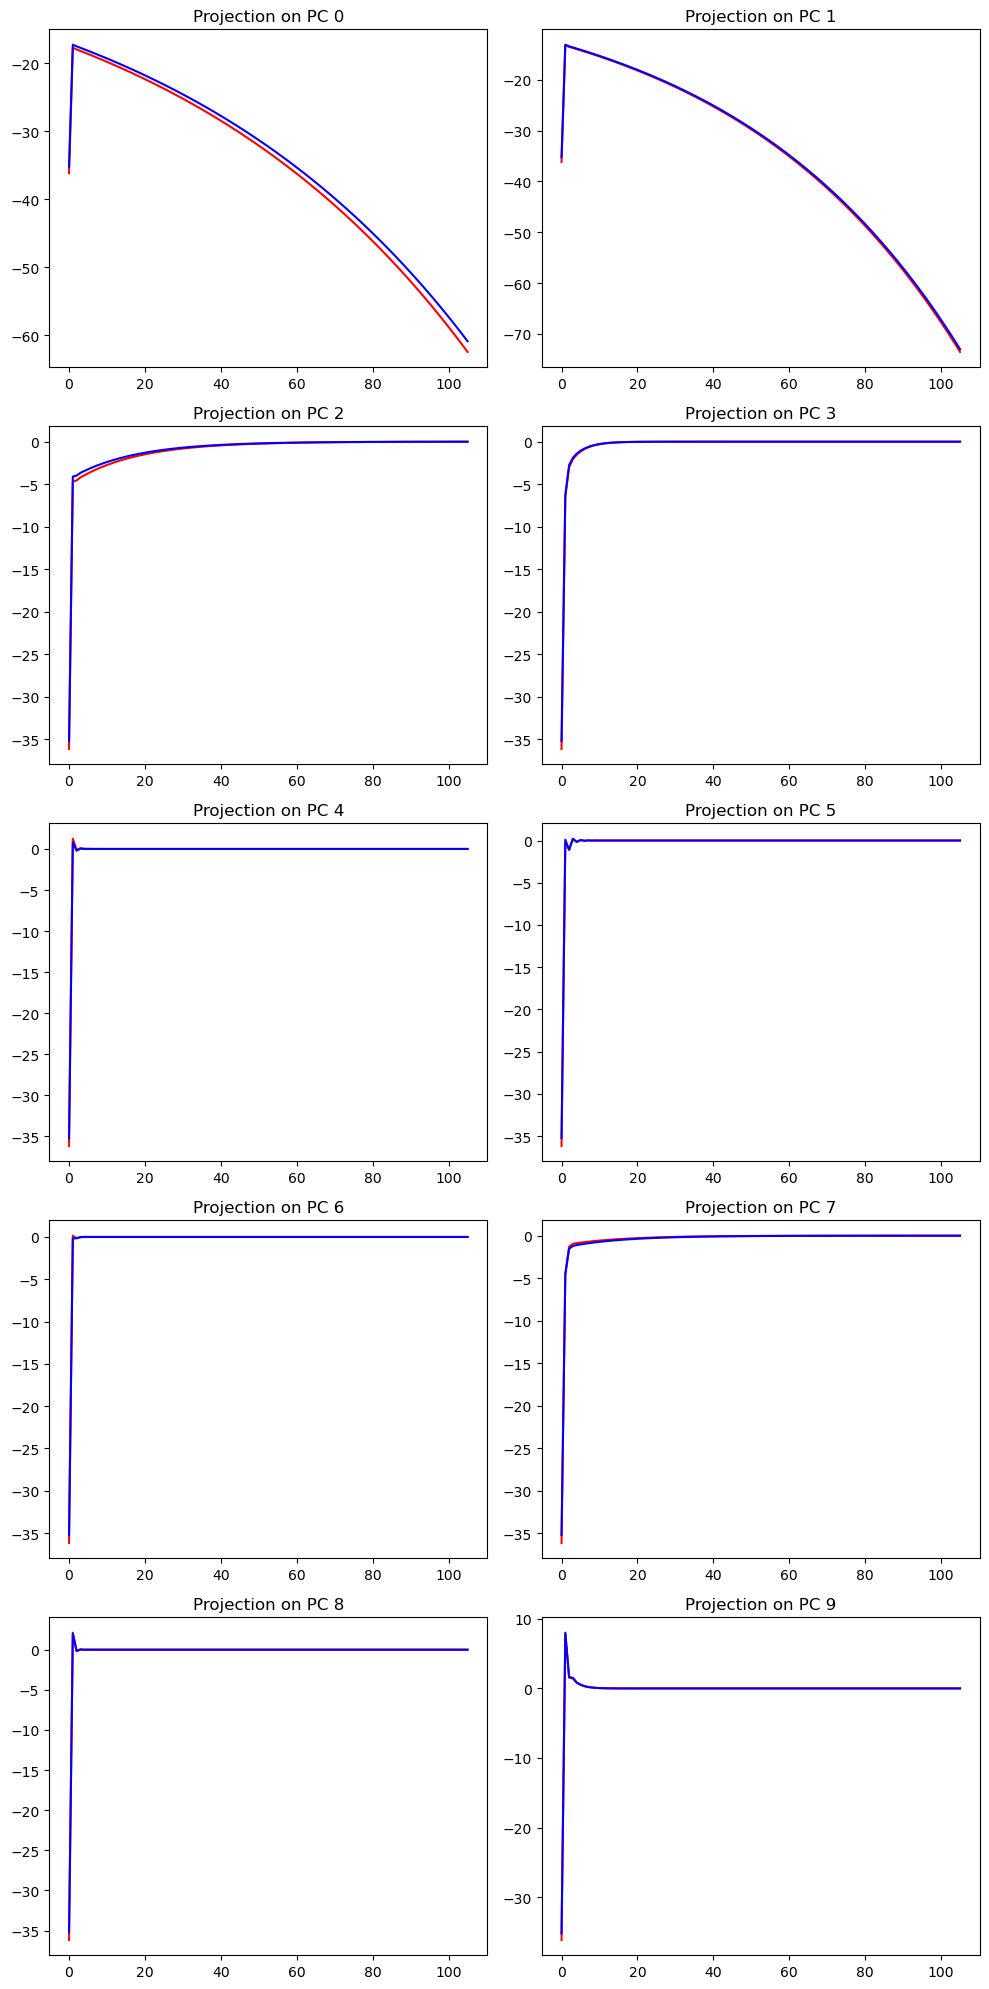

In [26]:
fig, axs = plt.subplots(5, 2, figsize=(10, 20))

for i in range(10):
    val_proj0 = val_X_rec0[:,i]
    val_proj1 = val_X_rec1[:,i]

    axs[i//2, i%2].plot(val_proj0, c='r', label="class 1")
    axs[i//2, i%2].plot(val_proj1, c='b', label="class 0")
    axs[i//2, i%2].set_title(f'Projection on PC {i}')

    # axs[i//2, i%2].set_ylim(-10,10)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

Relative error of reconstructed trajectories

In [28]:
# Reconstructing the whole trajectory from initial condition

val_X_rec = np.empty_like(val_X_red2)

for n in range(val_X_red2.shape[1]):
    val_X_rec[:,n,:] = np.dot(val_X_red2[:,0,:], K0**n)

val_X_rec = rearrange(val_X_rec, 'b t f -> (b t) f')
val_X_rec = dmd.emb_engine.inverse_transform(val_X_rec)
val_X_rec = rearrange(val_X_rec, '(b t) f -> b t f', b = val_X.shape[0], t=val_X.shape[1], f=320)

In [29]:
rel_e = [np.linalg.norm(val_X[:,t,:] - val_X_rec[:,t,:], ord='fro', axis=(0,1))**2 / 
         np.linalg.norm(val_X[:,t,:], ord='fro', axis=(0,1))**2 
         for t in range(val_X.shape[1])]

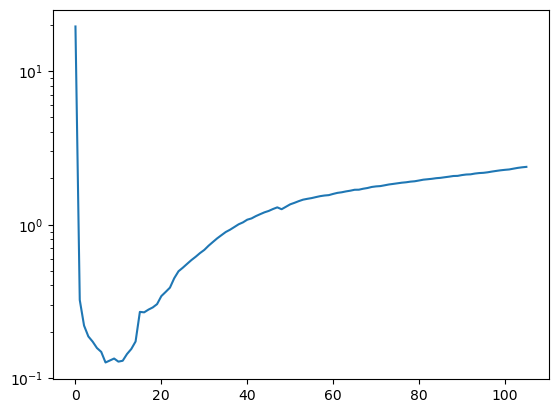

In [30]:
plt.plot(rel_e)
plt.yscale('log')
plt.show()

In [31]:
y = classifier.predict(val_X_rec[:,-1,:])
print(accuracy_score(val_y, y))

0.5376884422110553


In [104]:
# Reconstructing the whole trajectory step by step

val_X_rec = np.empty_like(val_X_red2)

val_X_rec[:,0,:] = val_X_red2[:,0,:]
for n in range(1, val_X_red2.shape[1]):
    val_X_rec[:,n,:] = np.dot(val_X_red2[:,n-1,:], K0)

val_X_rec = rearrange(val_X_rec, 'b t f -> (b t) f')
val_X_rec = dmd.emb_engine.inverse_transform(val_X_rec)
val_X_rec = rearrange(val_X_rec, '(b t) f -> b t f', b = val_X.shape[0], t=val_X.shape[1], f=256)

In [105]:
rel_e = [np.linalg.norm(val_X[:,t,:] - val_X_rec[:,t,:], ord='fro', axis=(0,1))**2 / 
         np.linalg.norm(val_X[:,t,:], ord='fro', axis=(0,1))**2 
         for t in range(val_X.shape[1])]

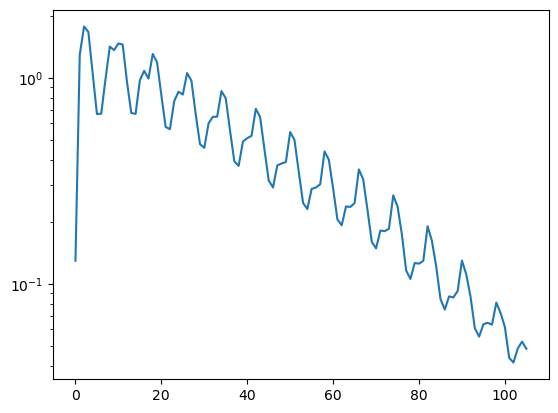

In [106]:
plt.plot(rel_e)
plt.yscale('log')
plt.show()

In [112]:
y = classifier.predict(val_X_rec[:,-1,:])
print(accuracy_score(val_y, y))

0.8844221105527639


Check if there's some correspondence between projected states and ground truth

In [28]:
val_X_proj.shape

(199, 106, 2)

In [4]:
from dataset.utils import ground_truth

nodes_gt, node_sums_gt, times_gt, edges_gt = ground_truth("facebook_ct1")

995it [00:06, 147.63it/s]


In [5]:
train_node_sums_gt, val_node_sums_gt, train_times_gt, val_times_gt = train_test_split(np.array(node_sums_gt), np.array(times_gt), test_size=0.2, random_state=seed)

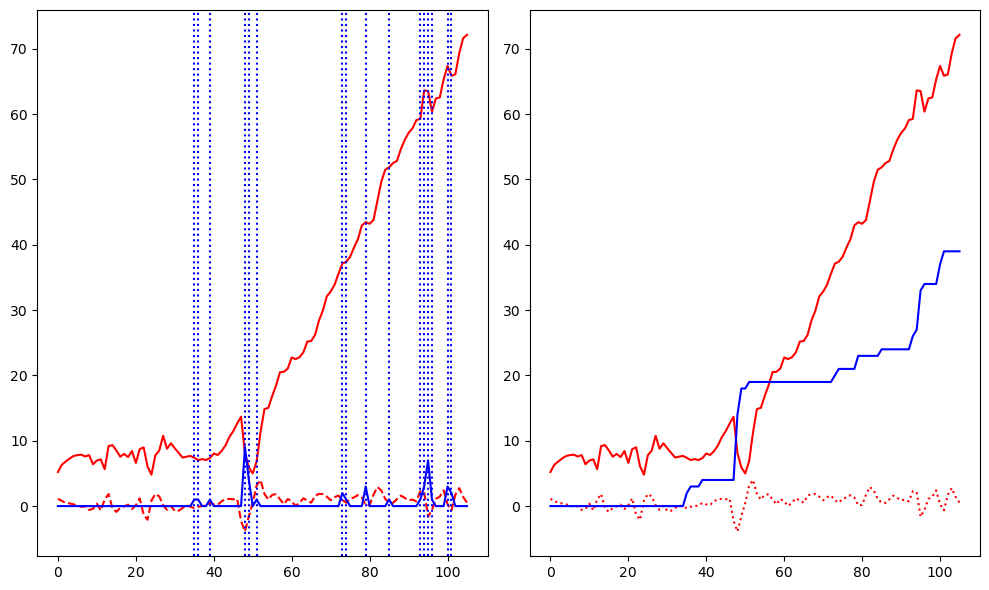

1.0


In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

val_proj = val_X_proj[:,:,0]
der_val_proj = np.gradient(val_proj, axis=1)
idx = 7

axs[0].plot(val_proj[idx], c='r', label="Proj trajectory")
axs[0].plot(der_val_proj[idx], c='r', linestyle='dashed', label="Derivative")
axs[0].plot(val_times_gt[idx], c='b', label="Time GT")

idx_t = np.where(val_times_gt[idx] != 0)[0]
for i in idx_t:
    axs[0].axvline(x=i, color='b', linestyle='dotted')

axs[1].plot(val_proj[idx], c='r', label="Proj trajectory")
axs[1].plot(der_val_proj[idx], c='r', linestyle='dotted', label="Derivative")
axs[1].plot(val_node_sums_gt[idx], c='b', label="Node sums GT")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

print(val_y[idx])

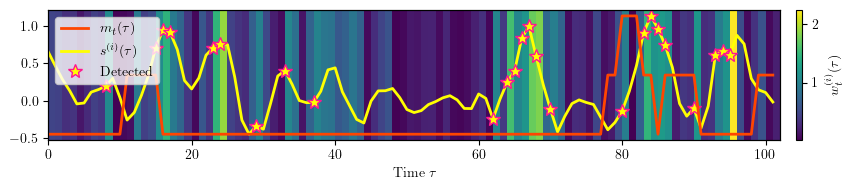

In [15]:
import matplotlib.pyplot as plt

# Configure Matplotlib to use LaTeX for text rendering
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern Roman']

idx = 0

window_size = 5
threshold = np.mean(der_val_proj[idx]) + np.std(der_val_proj[idx])

# Moving average
signal = der_val_proj[idx]
signal = np.convolve(signal, np.ones(window_size)/window_size, mode='valid')
derivative = np.gradient(signal)

fig, ax = plt.subplots(figsize=(8, 2))

# Plot the trajectory of val_proj
ax.plot(signal, c='yellow', label=r"$s^{(i)}(\tau)$", zorder=1, linewidth=2)

# Create a secondary y-axis
ax2 = ax.twinx()

# Plot the ground truth val_times_gt
filter = np.ones(window_size)
ground_truth_c = np.convolve(val_times_gt[idx], filter, mode='valid')
ax2.plot(ground_truth_c, c='orangered', label=r"$m_t(\tau)$", zorder=1, linewidth=2)

# Create a color scale using the derivative der_val_proj
derivative = der_val_proj[idx][window_size//2:-window_size//2+1]
detected = np.where(np.abs(derivative) > threshold)[0]
im = ax.imshow(np.abs(derivative.reshape(1,-1)), cmap='viridis', aspect='auto', alpha=1, zorder=0,
               extent=[0, derivative.shape[0], ax.get_ylim()[0], ax.get_ylim()[1]])

# Add detected points
det = np.zeros_like(ground_truth_c)
det[detected] = 1
ax.plot(np.where(det, signal, np.nan),
        '*', markerfacecolor='yellow', markeredgecolor='deeppink', markersize=10,
         label='Detected', zorder=2)

# Add a colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'$w_t^{(i)}(\tau)$')

# Add labels and legend
ax.set_xlabel(r'Time $\tau$')

# Combine handles and labels from both axes
handles, labels = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles2 += handles
labels2 += labels

# Add a single legend
ax2.legend(handles2, labels2, loc='upper left')
# legend.set_zorder(100)

# Hide the secondary y-axis
ax2.yaxis.set_visible(False)

# Adjust layout
plt.tight_layout()

# Move the colorbar out of the plot
cbar.ax.set_position([1.001, 0.275, 0.05, 0.65])

# Show the plot
plt.show()

In [55]:
fig.savefig("plots/test.pdf", bbox_inches='tight')

In [42]:
derivative.shape

(102,)

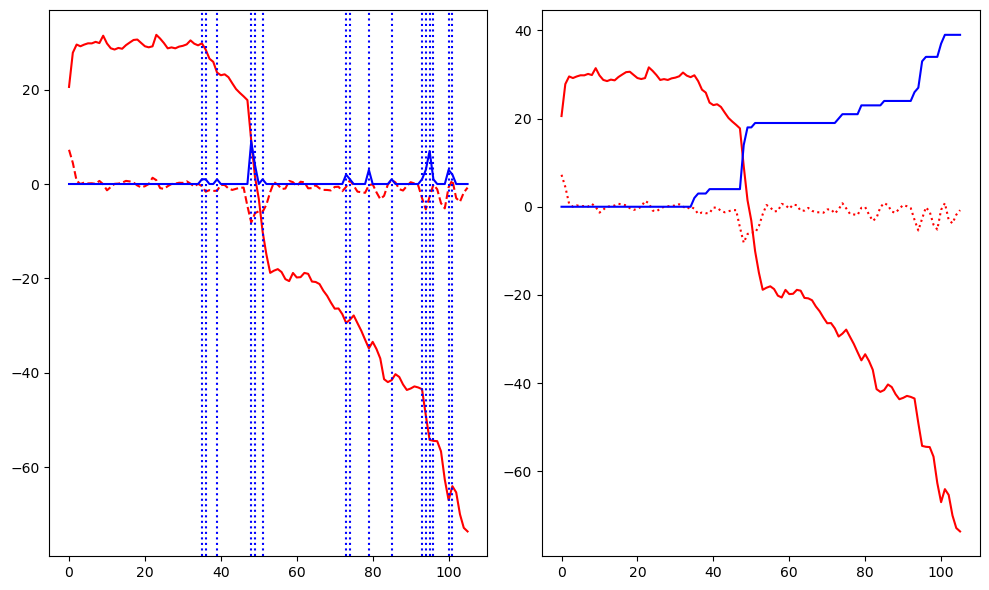

1.0


In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

val_proj = val_X_proj[:,:,1]
der_val_proj = np.gradient(val_proj, axis=1)
idx = 7

axs[0].plot(val_proj[idx], c='r', label="Proj trajectory")
axs[0].plot(der_val_proj[idx], c='r', linestyle='dashed', label="Derivative")
axs[0].plot(val_times_gt[idx], c='b', label="Time GT")

idx_t = np.where(val_times_gt[idx] != 0)[0]
for i in idx_t:
    axs[0].axvline(x=i, color='b', linestyle='dotted')

axs[1].plot(val_proj[idx], c='r', label="Proj trajectory")
axs[1].plot(der_val_proj[idx], c='r', linestyle='dotted', label="Derivative")
axs[1].plot(val_node_sums_gt[idx], c='b', label="Node sums GT")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

print(val_y[idx])

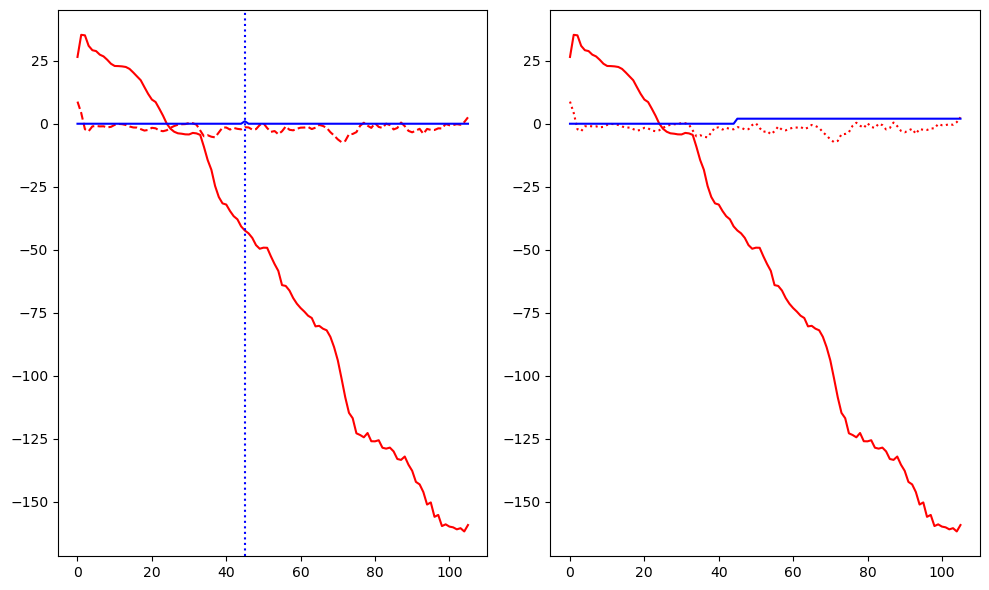

0.0


In [17]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

val_proj = val_X_proj[:,:,0] + val_X_proj[:,:,1]
der_val_proj = np.gradient(val_proj, axis=1)
idx = 2

axs[0].plot(val_proj[idx], c='r', label="Proj trajectory")
axs[0].plot(der_val_proj[idx], c='r', linestyle='dashed', label="Derivative")
axs[0].plot(val_times_gt[idx], c='b', label="Time GT")

idx_t = np.where(val_times_gt[idx] != 0)[0]
for i in idx_t:
    axs[0].axvline(x=i, color='b', linestyle='dotted')

axs[1].plot(val_proj[idx], c='r', label="Proj trajectory")
axs[1].plot(der_val_proj[idx], c='r', linestyle='dotted', label="Derivative")
axs[1].plot(val_node_sums_gt[idx], c='b', label="Node sums GT")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

print(val_y[idx])

# Spatial GT

In [4]:
from dataset.utils import ground_truth

nodes_gt, node_sums_gt, times_gt, edges_gt = ground_truth("facebook_ct1")
train_node_sums_gt, val_node_sums_gt, train_times_gt, val_times_gt = train_test_split(np.array(node_sums_gt), np.array(times_gt), test_size=0.2, random_state=seed)

995it [00:06, 156.01it/s]


In [5]:
node_states[0].shape

torch.Size([106, 100, 320])

In [6]:
from sklearn.decomposition import PCA

nodes0 = node_states[0][-1]

pca4 = PCA(n_components=10)
X_red4 = pca4.fit_transform(nodes0)

In [7]:
node_label0 = node_labels[0][-1,:,0]

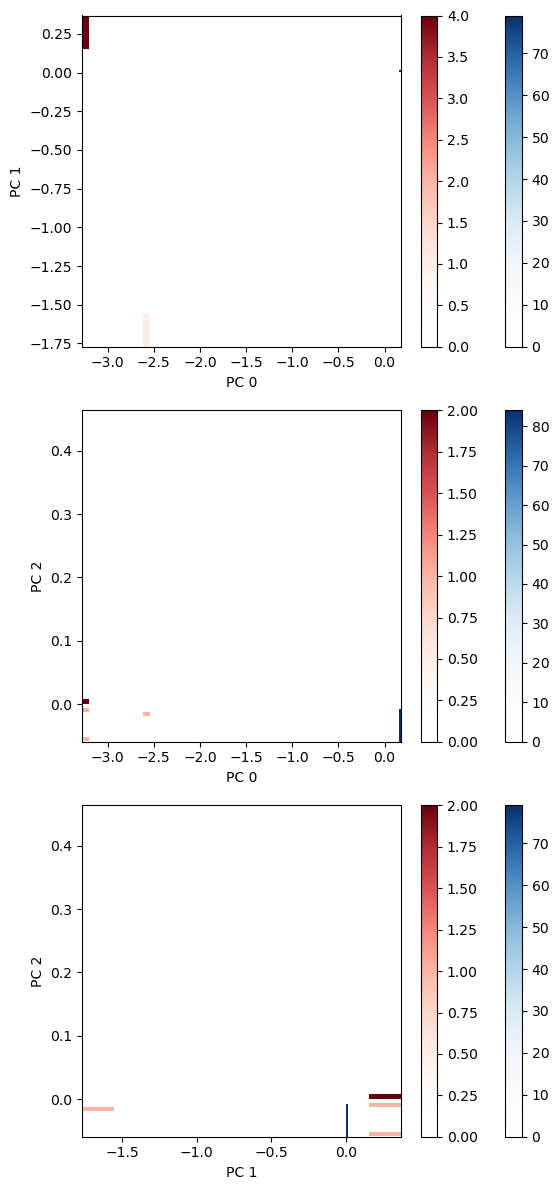

In [8]:
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

idx0 = node_label0 == 0
idx1 = node_label0 == 1
label_0 = X_red4[idx0]
label_1 = X_red4[idx1]

# modify existing Reds colormap with a linearly fading alpha
red = pl.cm.Reds  # original colormap
fading_red = red(np.arange(red.N)) # extract colors
fading_red[:, -1] = np.linspace(0, 1, red.N) # modify alpha
fading_red = ListedColormap(fading_red) # convert to colormap

blue = pl.cm.Blues  # original colormap
fading_blue = blue(np.arange(blue.N)) # extract colors
fading_blue[:, -1] = np.linspace(0, 1, blue.N) # modify alpha
fading_blue = ListedColormap(fading_blue) # convert to colormap

# Calculate min and max values for each PC
pc0_min, pc0_max = min(X_red4[:, 0]), max(X_red4[:, 0])
pc1_min, pc1_max = min(X_red4[:, 1]), max(X_red4[:, 1])
pc2_min, pc2_max = min(X_red4[:, 2]), max(X_red4[:, 2])

# Create a figure with two subplots
fig, axs = plt.subplots(3, 1, figsize=(6, 12))

# PC0 vs PC1
# Plot the first histogram in the first subplot
hist1 = axs[0].hist2d(label_0[:, 0], label_0[:, 1], bins=10, cmap=fading_blue, label='Label 0')
hist2 = axs[0].hist2d(label_1[:, 0], label_1[:, 1], bins=10, cmap=fading_red, label='Label 1')
axs[0].set_xlabel('PC 0')
axs[0].set_ylabel('PC 1')
axs[0].set_xlim(pc0_min, pc0_max)
axs[0].set_ylim(pc1_min, pc1_max)
plt.colorbar(hist1[3], ax=axs[0])
plt.colorbar(hist2[3], ax=axs[0])

# PC0 vs PC2
# Plot the first histogram in the first subplot
hist3 = axs[1].hist2d(label_0[:, 0], label_0[:, 2], bins=10, cmap=fading_blue, label='Label 0')
hist4 = axs[1].hist2d(label_1[:, 0], label_1[:, 2], bins=10, cmap=fading_red, label='Label 1')
axs[1].set_xlabel('PC 0')
axs[1].set_ylabel('PC 2')
axs[1].set_xlim(pc0_min, pc0_max)
axs[1].set_ylim(pc2_min, pc2_max)
plt.colorbar(hist3[3], ax=axs[1])
plt.colorbar(hist4[3], ax=axs[1])

# PC1 vs PC2
# Plot the first histogram in the first subplot
hist5 = axs[2].hist2d(label_0[:, 1], label_0[:, 2], bins=10, cmap=fading_blue, label='Label 0')
hist6 = axs[2].hist2d(label_1[:, 1], label_1[:, 2], bins=10, cmap=fading_red, label='Label 1')
axs[2].set_xlabel('PC 1')
axs[2].set_ylabel('PC 2')
axs[2].set_xlim(pc1_min, pc1_max)
axs[2].set_ylim(pc2_min, pc2_max)
plt.colorbar(hist5[3], ax=axs[2])
plt.colorbar(hist6[3], ax=axs[2])

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [58]:
train_X.shape

(796, 106, 256)

In [59]:
node_states[0].shape

torch.Size([106, 100, 256])

In [9]:
from koopman.dmd import DMD
from einops import rearrange

dim_red = 10
method = 'PCA'

g_idx = 20

# compute local Koopman operator
dmd = DMD(rearrange(node_states[g_idx], 't n f -> n t f'), k=dim_red, emb=method)

K0 = dmd.compute_KOP()

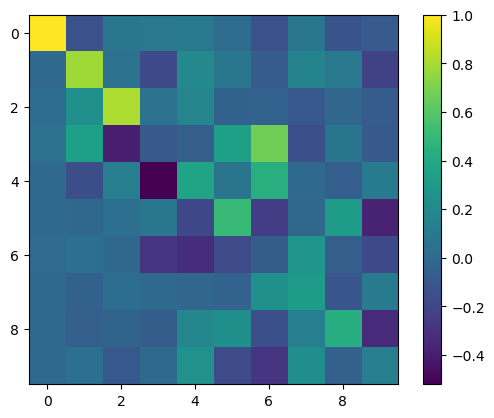

In [10]:
plt.imshow(K0)
plt.colorbar()

/tmp/ipykernel_1280085/1226691090.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


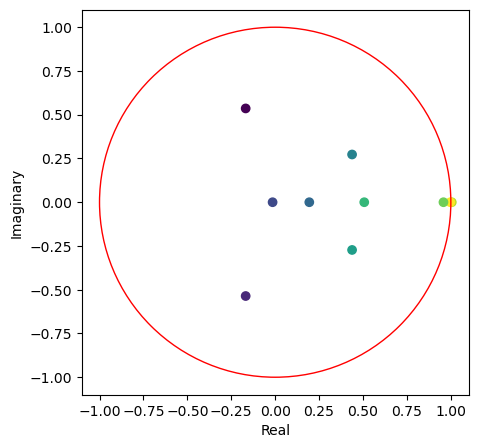

In [11]:
E, V = np.linalg.eig(K0)

# sort eigenvalues and eigenvectors
idx = np.argsort(np.abs(E))[::-1]
E = E[idx]
V = V[:, idx]

cmap = plt.cm.get_cmap('viridis')

plt.figure(figsize=(5,5))
plt.scatter(E.real, E.imag, c=idx, cmap=cmap)
circle = plt.Circle((0, 0), 1, color='r', fill=False)
plt.gca().add_patch(circle)
plt.ylabel('Imaginary') 
plt.xlabel('Real')
plt.show()

Distribution of eigenvalues for the two classes

In [12]:
from koopman.dmd import DMD
import seaborn as sns
import matplotlib

dim_red = 10
method = 'PCA'

node_states_1 = [node_states[i] for i in range(len(node_states)) if dataset.targets[i] == 1]

eigs_1 = np.empty((len(node_states_1), 2, dim_red))

for g in tqdm(range(len(node_states_1))):
    # compute local Koopman operator
    dmd = DMD(rearrange(node_states_1[g], 't n f -> n t f'), k=dim_red, emb=method)

    K = dmd.compute_KOP()

    E, _ = np.linalg.eig(K)

    # sort eigenvalues and eigenvectors
    idx = np.argsort(np.abs(E))[::-1]
    E = E[idx]

    eigs_1[g] = (E.real, E.imag)

node_states_0 = [node_states[i] for i in range(len(node_states)) if dataset.targets[i] == 0]

eigs_0 = np.empty((len(node_states_0), 2, dim_red))

for g in tqdm(range(len(node_states_0))):
    # compute local Koopman operator
    dmd = DMD(rearrange(node_states_0[g], 't n f -> n t f'), k=dim_red, emb=method)

    K = dmd.compute_KOP()

    E, _ = np.linalg.eig(K)

    # sort eigenvalues and eigenvectors
    idx = np.argsort(np.abs(E))[::-1]
    E = E[idx]

    eigs_0[g] = (E.real, E.imag)

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 60.13it/s]


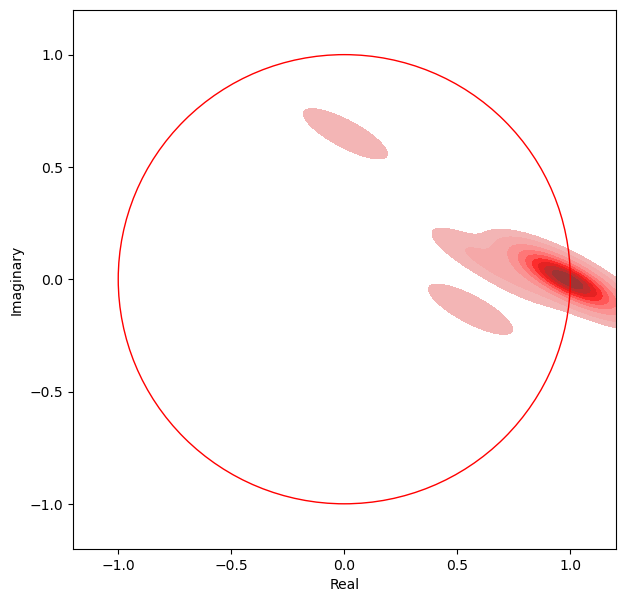

In [13]:

cmap = matplotlib.colormaps['viridis']

plt.figure(figsize=(7,7))
# plt.scatter(E.real, E.imag, c=idx, cmap=cmap)
# for d in range(dim_red):
d = 1
sns.kdeplot(x=eigs_1[:,0,d], y=eigs_1[:,1,d], fill = True, color='b', label = "class 1")

sns.kdeplot(x=eigs_0[:,0,d], y=eigs_0[:,1,d], fill = True, color='r', label = "class 0")

circle = plt.Circle((0, 0), 1, color='r', fill=False)
plt.gca().add_patch(circle)
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.ylabel('Imaginary') 
plt.xlabel('Real')
plt.show()


In [14]:
from koopman.dmd import DMD

dim_red = 10
method = 'PCA'

g_idx = 20

# compute local Koopman operator
dmd = DMD(rearrange(node_states[g_idx], 't n f -> n t f'), k=dim_red, emb=method)

K0 = dmd.compute_KOP()
E, V = np.linalg.eig(K0)

# sort eigenvalues and eigenvectors
idx = np.argsort(np.abs(E))[::-1]
E = E[idx]
V = V[:, idx]

vr = V.real

# Calculate the projection
nodes_red0 = dmd.emb_engine.transform(rearrange(node_states[g_idx], 't n f -> (n t) f'))
nodes_red0 = rearrange(nodes_red0, '(n t) f -> n t f', n = node_states[g_idx].shape[1], t=node_states[g_idx].shape[0], f=dim_red)
nodes_proj0 = np.dot(nodes_red0, vr)

In [15]:
from dataset.utils import ground_truth

nodes_gt, node_sums_gt, times_gt, edges_gt = ground_truth("facebook_ct1")

995it [00:06, 149.91it/s]


In [67]:
times_gt[0].shape

torch.Size([106])

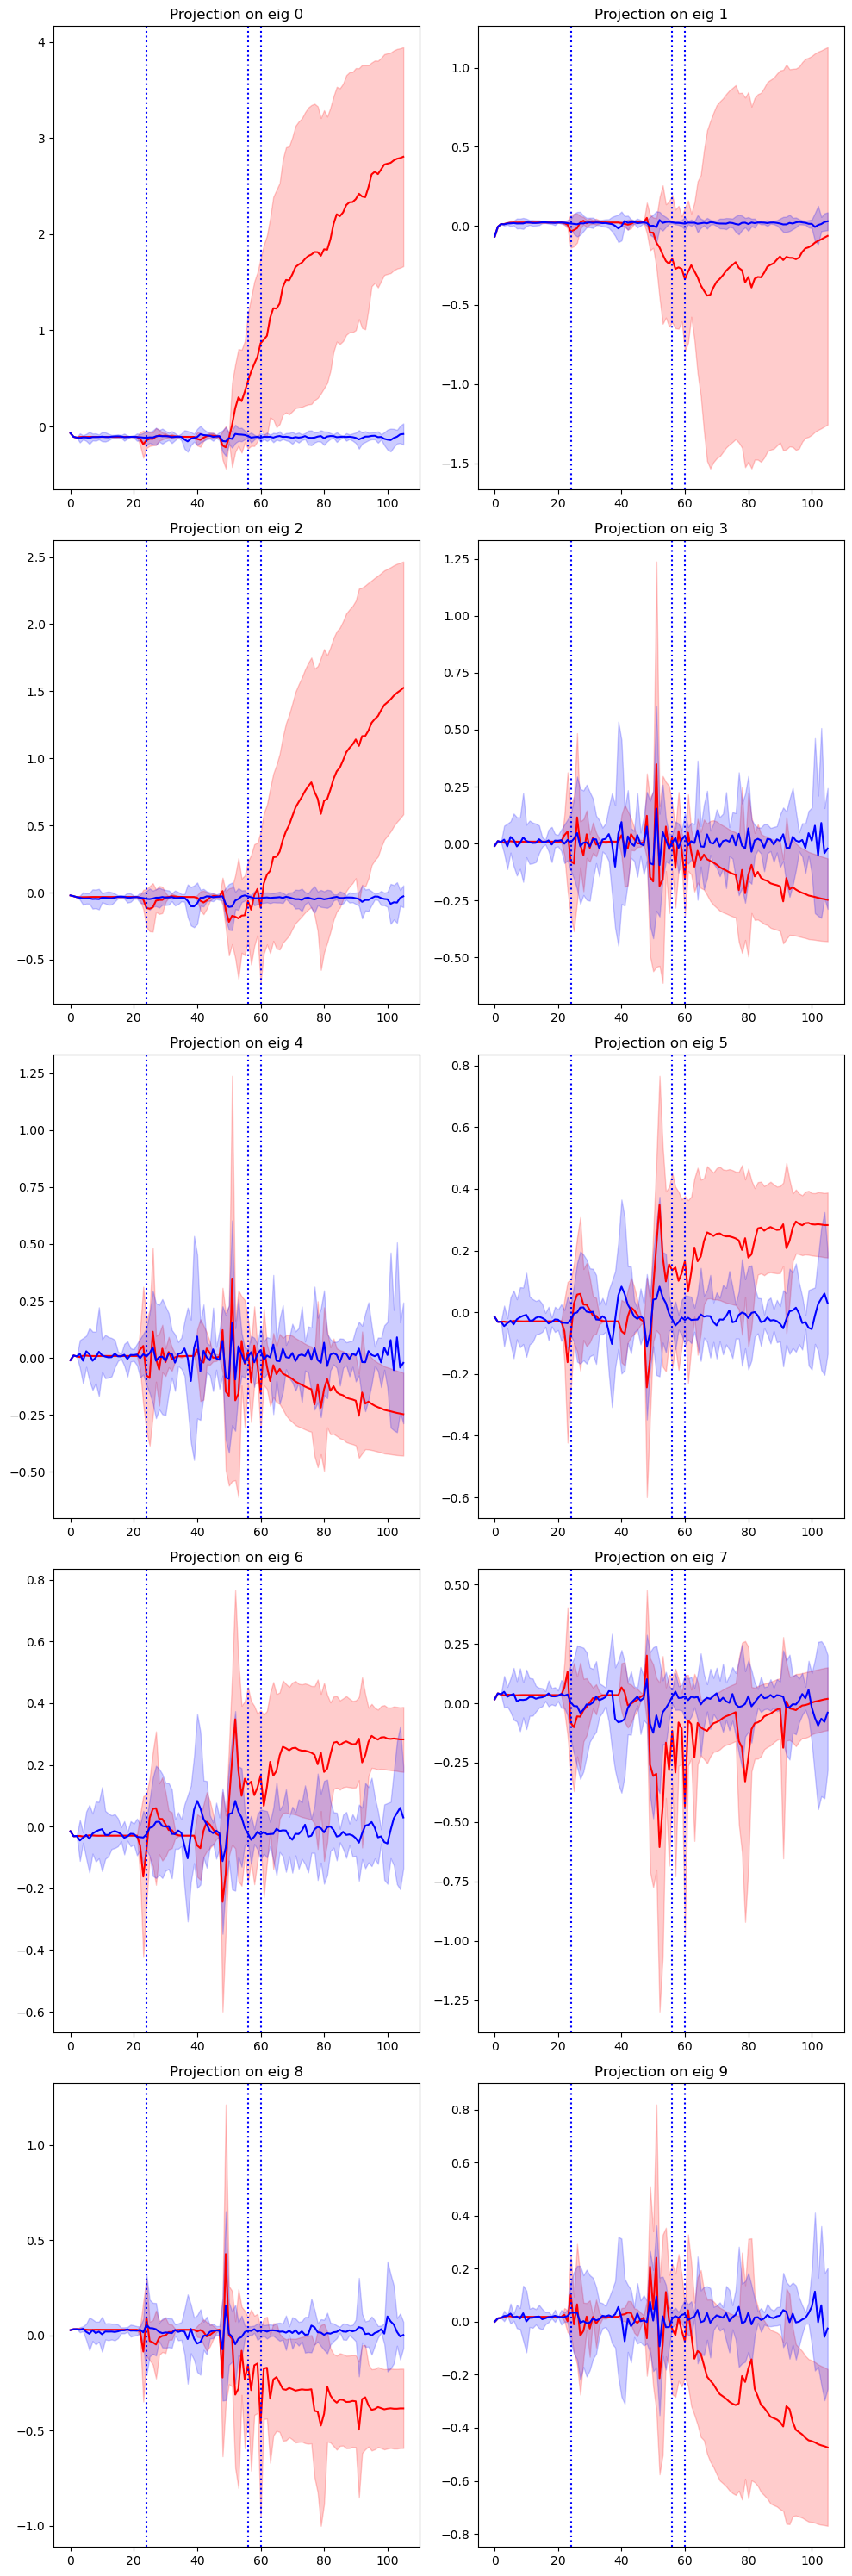

In [16]:
fig, axs = plt.subplots(5, 2, figsize=(10, 30))

node_y = node_labels[g_idx][-1,:,0].numpy()

for i in range(10):
    val_proj = nodes_proj0[:,:,i]

    m = val_proj[node_y.astype(bool)].mean(axis=0)
    s = val_proj[node_y.astype(bool)].std(axis=0)
    m_not = val_proj[~node_y.astype(bool)].mean(axis=0)
    s_not = val_proj[~node_y.astype(bool)].std(axis=0)

    axs[i//2,i%2].plot(m, c='r', label="class 1")
    axs[i//2,i%2].fill_between(np.arange(m.shape[0]), m-s, m+s, color='r', alpha=0.2)
    axs[i//2,i%2].plot(m_not, c='b', label="class 0")
    axs[i//2,i%2].fill_between(np.arange(m.shape[0]), m_not-s_not, m_not+s_not, color='b', alpha=0.2)
    axs[i//2,i%2].set_title(f'Projection on eig {i}')

    idx_t = np.where(times_gt[0] != 0)[0]
    for j in idx_t:
        axs[i//2,i%2].axvline(x=j, color='b', linestyle='dotted')


# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

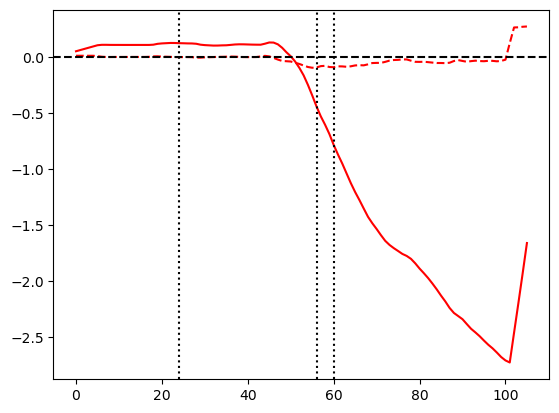

In [44]:
node_y = node_labels[g_idx][-1,:,0].numpy()

val_proj = nodes_proj0[:,:,0]

m = val_proj[node_y.astype(bool)].mean(axis=0)
m_not = val_proj[~node_y.astype(bool)].mean(axis=0)

m = np.convolve(m, np.ones(10)/10, mode='same')
der_m = np.gradient(m, axis=0)
# der_m_not = np.gradient(m_not, axis=0)

plt.plot(m, c='r', label="class 1")
plt.plot(der_m, c='r', linestyle='dashed', label="Derivative")
# plt.plot(m_not, c='b', label="class 0")
# plt.plot(der_m_not, c='b', linestyle='dashed', label="Derivative")

plt.axhline(y=0, color='black', linestyle='--')

idx_t = np.where(times_gt[0] != 0)[0]
for j in idx_t:
    plt.axvline(x=j, color='black', linestyle='dotted')

plt.show()

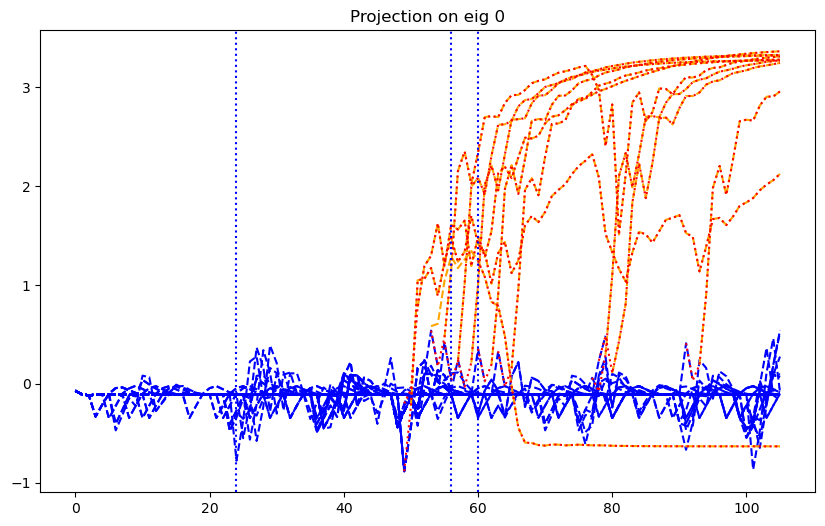

In [16]:
fig, axs = plt.subplots(1, 1, figsize=(10, 6))

node_y = node_labels[g_idx][:,:,0].numpy().T

i=0

val_proj = nodes_proj0[:,:,i]

m = np.where(node_y.astype(bool), val_proj, np.NaN)
m_not = np.where(~node_y.astype(bool), val_proj, np.NaN)
m_gt = np.where((nodes_gt[g_idx].T != 0).numpy().astype(bool), val_proj, np.NaN)

for l in range(m_not.shape[0]):
    axs.plot(m_not[l], c='b', label="class 0", linestyle='dashed')
for n in range(m.shape[0]):
    axs.plot(m[n], c='orange', label="class 1", linestyle='dashed')
for k in range(m_gt.shape[0]):
    axs.plot(m_gt[k], c='r', label="GT", linestyle='dotted')
axs.set_title(f'Projection on eig {i}')

idx_t = np.where(times_gt[0] != 0)[0]
for j in idx_t:
    axs.axvline(x=j, color='b', linestyle='dotted')
    
# Show the plot
plt.show()

# Plots for paper

In [2]:
from utils.utils import change_basis

dataset, states, node_states, node_labels = process_classification_dataset(config, "DynCRNN", device)
train_X, val_X, train_y, val_y, train_nodes, val_nodes = train_test_split(states.inputs, states.targets, node_states,
                                                  test_size=0.2, random_state=seed)

100%|██████████| 995/995 [04:44<00:00,  3.50it/s]


In [3]:
from dataset.utils import load_classification_dataset, ground_truth

nodes_gt, node_sums_gt, times_gt, edges_gt = ground_truth(config['dataset'], False)
edge_indexes, _, _ = load_classification_dataset(config['dataset'], False)

train_nodes_gt, val_nodes_gt, train_times_gt, val_times_gt, train_edge_indexes, val_edge_indexes = \
    train_test_split(
        nodes_gt, 
        torch.stack(times_gt).numpy(),
        edge_indexes,
        test_size=0.2, 
        random_state=seed
        )

995it [00:06, 159.27it/s]


In [30]:
min_n = 1000
min_g = 0

for g in range(len(val_nodes_gt)):
    gt = val_nodes_gt[g]
    if val_y[g] == 0:
        continue
    # if gt.shape[1] < min_n:
    min_n = gt.shape[1]
    min_g = g

    print(min_g, " ", min_n, " ", gt[-1].sum())

0   100   tensor(7.)
7   92   tensor(39.)
8   92   tensor(39.)
9   87   tensor(39.)
12   100   tensor(36.)
13   97   tensor(3.)
14   97   tensor(2.)
16   100   tensor(25.)
17   100   tensor(40.)
18   92   tensor(35.)
19   92   tensor(3.)
20   97   tensor(0.)
23   100   tensor(40.)
30   90   tensor(0.)
31   95   tensor(17.)
32   73   tensor(3.)
36   100   tensor(41.)
38   100   tensor(11.)
41   92   tensor(3.)
42   100   tensor(37.)
43   100   tensor(5.)
44   100   tensor(6.)
46   100   tensor(4.)
48   95   tensor(35.)
49   95   tensor(3.)
51   100   tensor(34.)
52   82   tensor(36.)
54   97   tensor(37.)
55   99   tensor(41.)
58   99   tensor(6.)
59   100   tensor(29.)
61   100   tensor(3.)
62   97   tensor(40.)
63   89   tensor(38.)
66   95   tensor(34.)
68   100   tensor(34.)
73   96   tensor(34.)
75   91   tensor(38.)
76   89   tensor(15.)
80   84   tensor(38.)
81   95   tensor(14.)
83   100   tensor(31.)
86   100   tensor(4.)
87   100   tensor(0.)
88   94   tensor(4.)
91   100   te

In [31]:
from koopman.dmd import DMD
from einops import rearrange

dim_red = 10
method = 'PCA'

g_idx = 76

# compute local Koopman operator
dmd = DMD(rearrange(val_nodes[g_idx], 't n f -> n t f'), k=dim_red, emb=method)

K0 = dmd.compute_KOP()

E, V = np.linalg.eig(K0)

# sort eigenvalues and eigenvectors
idx = np.argsort(np.abs(E))[::-1]
E = E[idx]
V = V[:, idx]

In [51]:
emb_engine = dmd.emb_engine
g = g_idx
mode_idx = 0
v = V.real

node_modes = change_basis(rearrange(val_nodes[g], 't n f -> n t f'), v, emb_engine)
weights_t = np.absolute(node_modes[:,:,mode_idx] - node_modes[:,:,mode_idx].mean())
weights_t = weights_t / weights_t.max()
weights = weights_t[:,-1]
node_gt_t = val_nodes_gt[g]
node_gt = node_gt_t[-1]

In [13]:
import matplotlib
import networkx as nx
import matplotlib.pyplot as plt

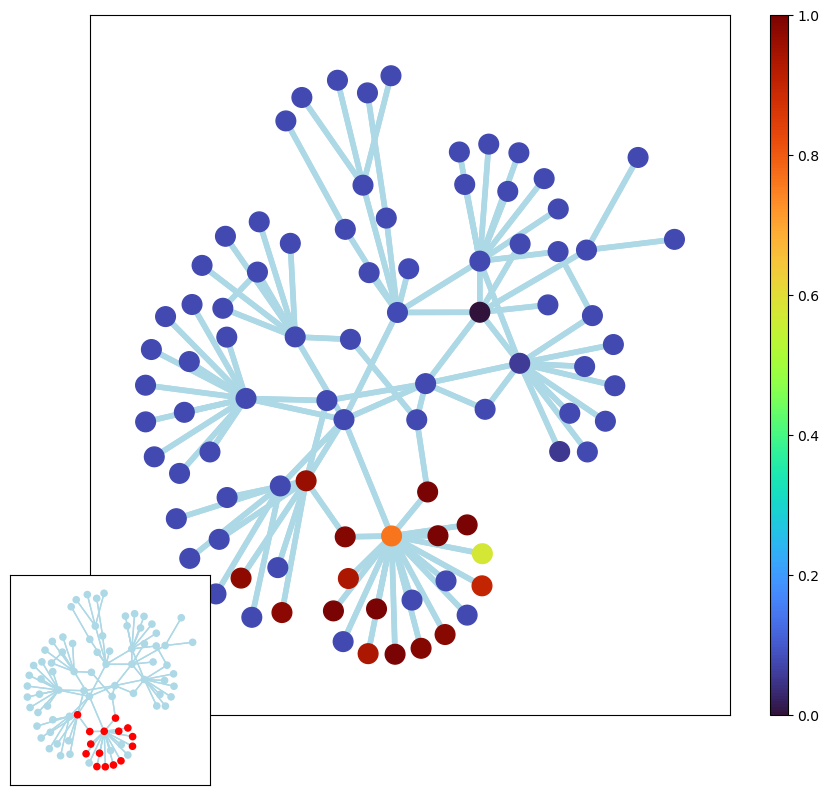

In [33]:
fig = plt.figure(figsize=(8, 7))

# Create the main plot axis
axs = fig.add_axes([0.1, 0.1, 1, 1])  # [left, bottom, width, height] in figure coordinates

G = nx.DiGraph()

edge_index = val_edge_indexes[g]

# Add edges
edge_index = torch.cat(edge_index, dim=1)
edge_index = torch.unique(edge_index.T, dim=0).T
G.add_edges_from(edge_index.T.tolist())

# Add nodes
num_nodes = edge_index.max().item() + 1
G.add_nodes_from(range(num_nodes))

# Plot the graph
pos = nx.kamada_kawai_layout(G)
cmap = matplotlib.colormaps.get_cmap('turbo')
norm = plt.Normalize(min(weights), max(weights))
pax = nx.draw_networkx_nodes(G, pos, ax=axs, node_color=norm(weights), cmap=cmap, vmin=0, vmax=1, node_size=200)
nx.draw_networkx_edges(G, pos, ax=axs, arrows=False, edge_color='lightblue', width=4)
# axs.set_title('Graph with weights')

plt.colorbar(pax, ax=axs, aspect=40)

# Create an inset axis within the first axis
# inset_ax = inset_axes(axs, width="30%", height="30%", loc='lower left')
inset_ax = fig.add_axes([0, 0, 0.25, 0.3])  # [left, bottom, width, height] in figure coordinates

# Plot the ground truth % FIXME: Check if this is correct
G_gt = nx.DiGraph()
G_gt.add_nodes_from(range(num_nodes))
G_gt.add_edges_from(edge_index.T.tolist())
colors = ['r' if node else 'lightblue' for node in node_gt.tolist()]
nx.draw_networkx_nodes(G_gt, pos, ax=inset_ax, node_color=colors, node_size=20)
nx.draw_networkx_edges(G_gt, pos, ax=inset_ax, arrows=False, edge_color='lightblue', width=1)
# inset_ax.set_title('Ground Truth Graph')

plt.show()

In [89]:
# Configure Matplotlib to use LaTeX for text rendering
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{amssymb}'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern Roman']
plt.rcParams['font.size'] = 14

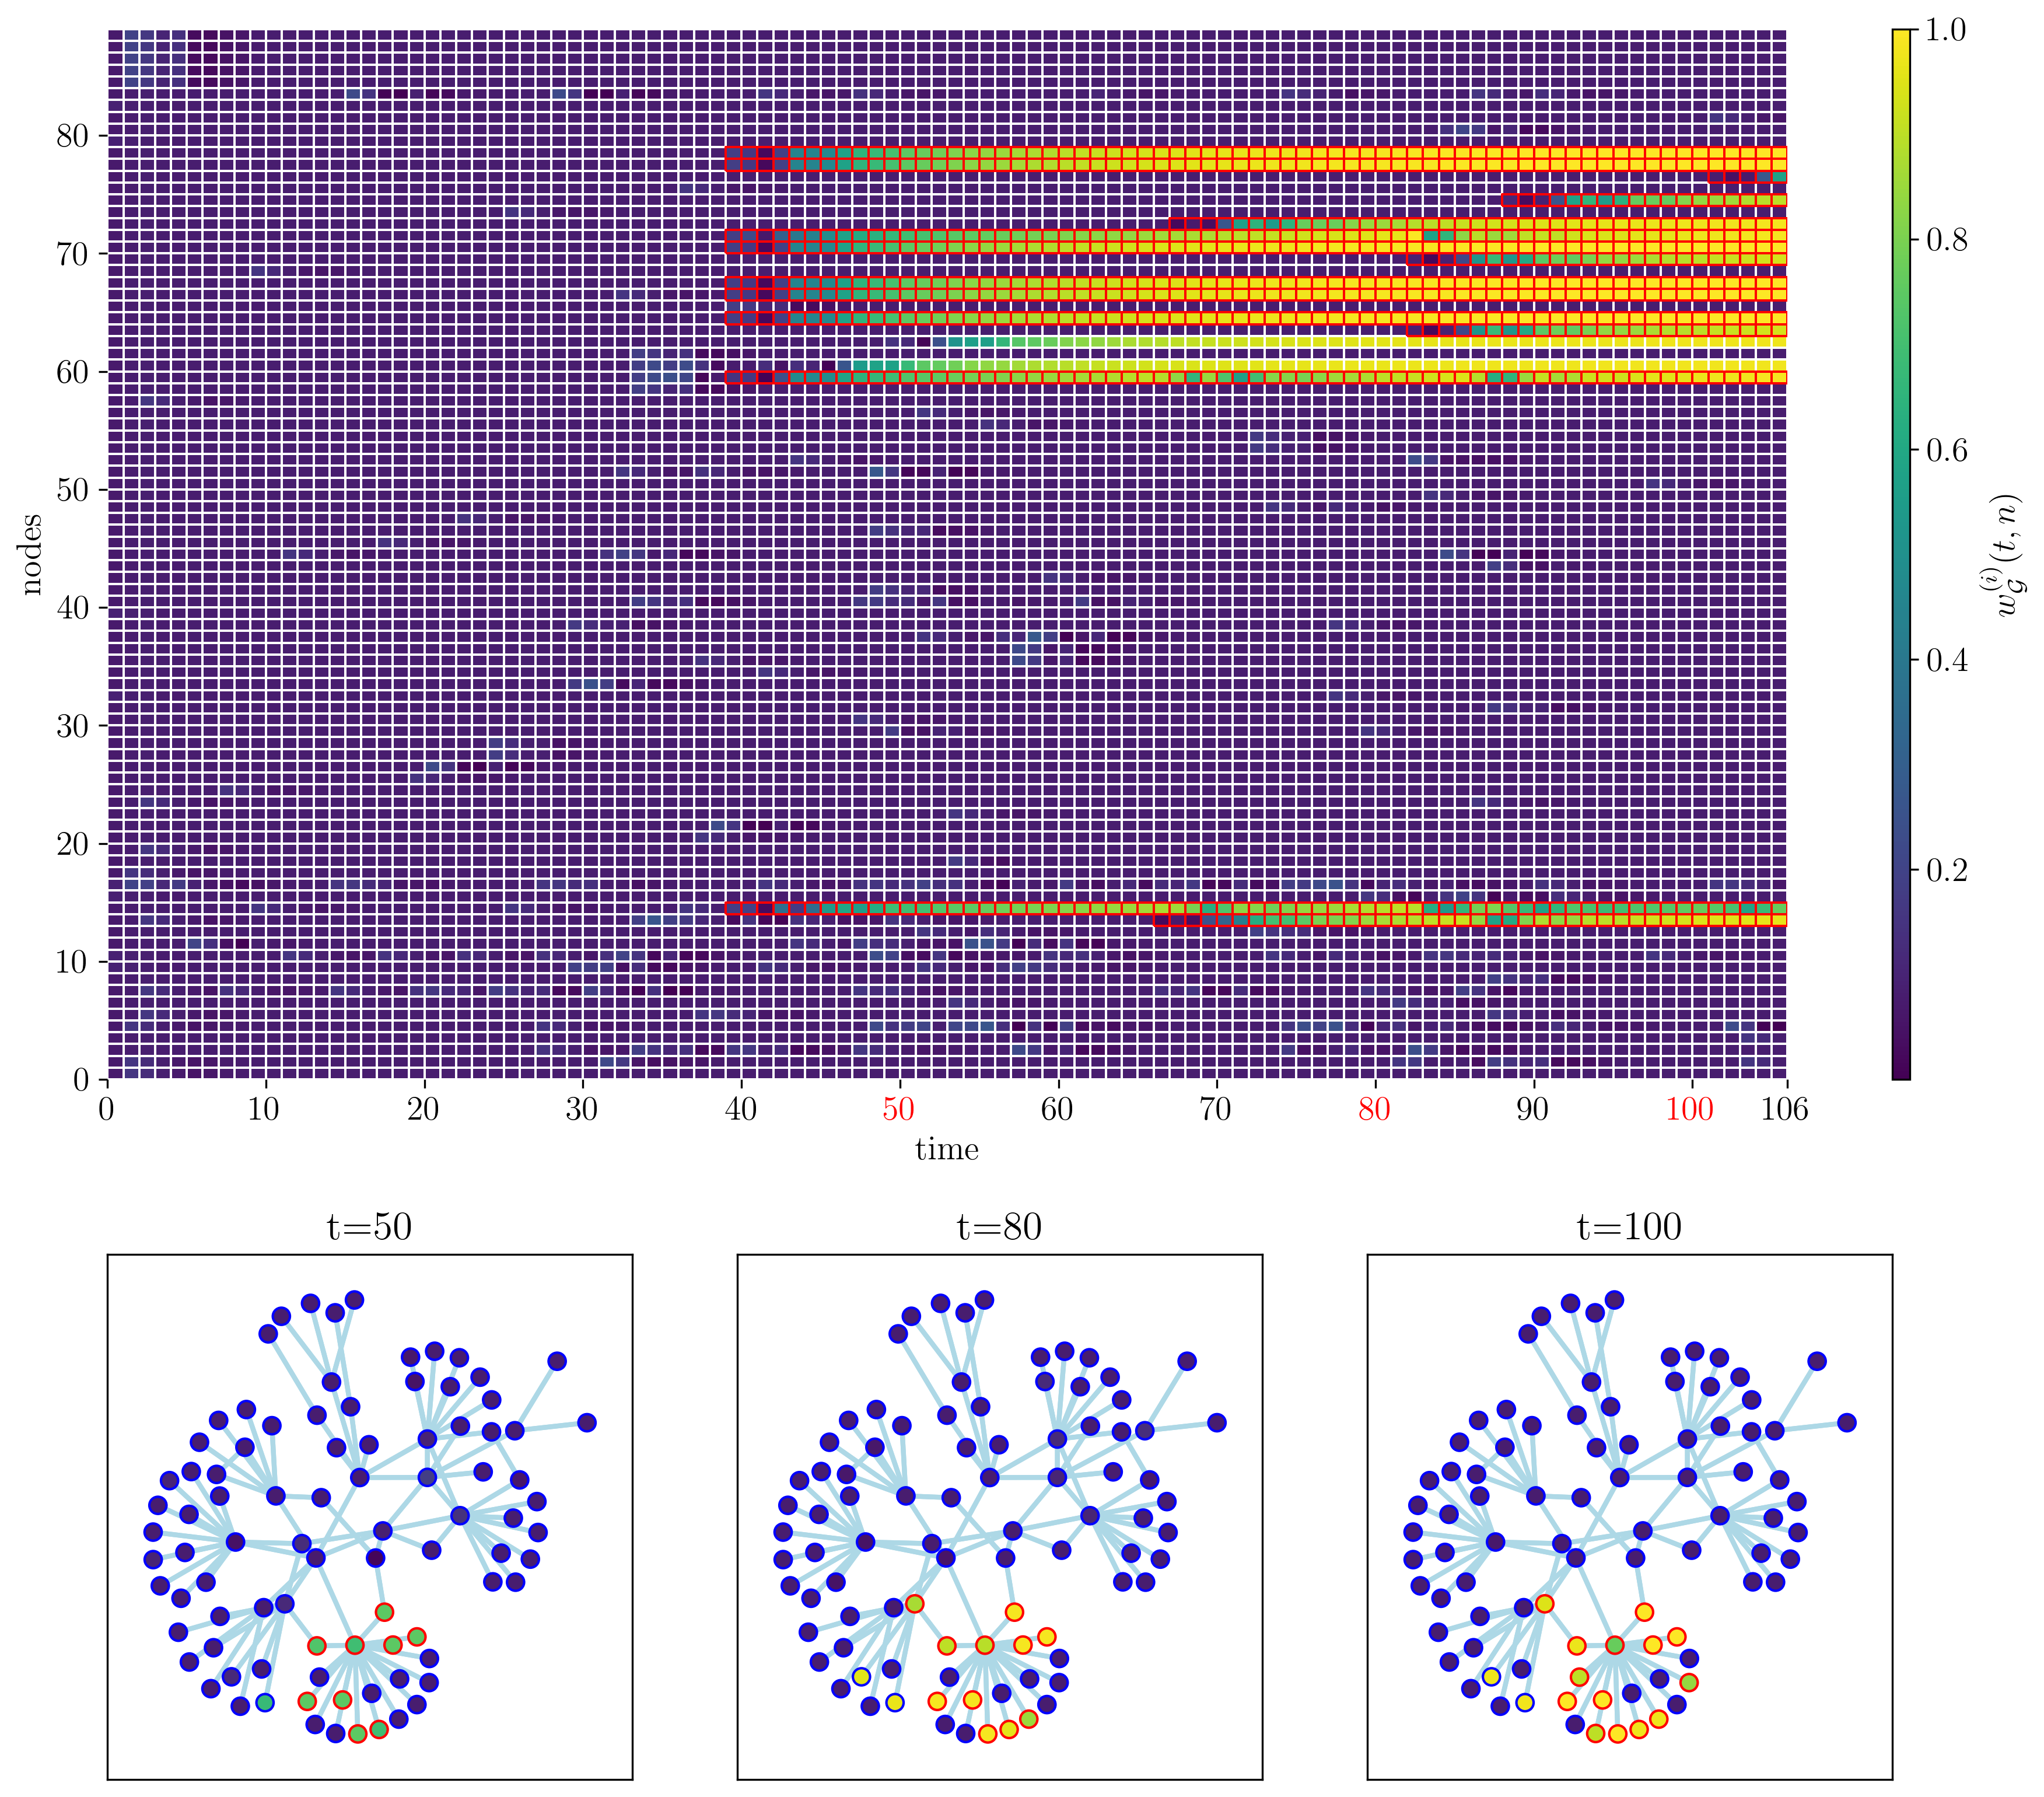

In [104]:
from matplotlib.colors import ListedColormap

fig = plt.figure(figsize=(12, 10))
fig.set_dpi(300)

# Create the main plot axis
ax = fig.add_axes([0, 0.4, 1, 0.6])  # [left, bottom, width, height] in figure coordinates

# Topology
edge_index = val_edge_indexes[g]
edge_index = torch.cat(edge_index, dim=1)
edge_index = torch.unique(edge_index.T, dim=0).T

# Create a mesh grid
x = np.arange(weights_t.shape[1] + 1)
y = np.arange(weights_t.shape[0] + 1)

transparent_cmap = ListedColormap([(1, 1, 1, 0) for _ in range(len(x)*len(y))])

# Create an array of edge colors based on node_gt_t
edge_colors = np.zeros((node_gt_t.T.shape[0], node_gt_t.T.shape[1], 4))
edge_colors[node_gt_t.T == 1] = [1, 0, 0, 1]  # Set red color for edges where node_gt_t is 1
c = ax.pcolormesh(x, y, weights_t, cmap='viridis', edgecolors=(1,1,1,1), linewidth=0.5)
c_gt = ax.pcolormesh(x, y, np.zeros_like(weights_t), cmap=transparent_cmap, edgecolors=edge_colors.reshape(-1, 4), linewidth=0.5)

# Add colorbar
cbar = plt.colorbar(c, ax=ax, label=r'$w_\mathcal{G}^{(i)}(t,n)$', aspect=60)

# Set labels and title
ax.set_xlabel('time')
ax.set_ylabel('nodes')

# Generate the time points
time_points = np.array([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 106])

# Set the xticks and xticklabels
ax.set_xticks(time_points)
ax.set_xticklabels([f'{int(t)}' for t in time_points])
xtick_colors = ['black' if t not in [50, 80, 100] else 'red' for t in time_points]
# Change the color of each x-tick individually
for xtick, color in zip(ax.get_xticklabels(), xtick_colors):
    xtick.set_color(color)

# Remove the grid box around the plot
ax.set_frame_on(False)


# Add graph
G = nx.DiGraph()
# Add edges
G.add_edges_from(edge_index.T.tolist())
# Add nodes
num_nodes = edge_index.max().item() + 1
G.add_nodes_from(range(num_nodes))

# Plot the graph
pos = nx.kamada_kawai_layout(G)
cmap = matplotlib.colormaps.get_cmap('viridis')


# Zoom at t=50
t1 = 50
ax1 = fig.add_axes([0, 0, 0.25, 0.3])  # [left, bottom, width, height]
ax1.set_title('t=50')

# ax1.annotate('',
#             xy=(0.2, 0.27), xycoords='figure fraction',
#             xytext=(0.42, 0.49), textcoords='figure fraction',
#             arrowprops=dict(facecolor='black', arrowstyle='->', connectionstyle='arc3,rad=-.2'))


edge_colors = ['r' if node else 'b' for node in node_gt_t[t1]]
nx.draw_networkx_nodes(G, pos, ax=ax1, node_color=weights_t[:,t1], 
                             cmap=cmap, vmin=0, vmax=1, node_size=50,
                             edgecolors=edge_colors, 
                             linewidths=1)
nx.draw_networkx_edges(G, pos, ax=ax1, arrows=False, edge_color='lightblue', width=2)


# Zoom at t=80
t2 = 80
ax2 = fig.add_axes([0.3, 0, 0.25, 0.3])  # [left, bottom, width, height]
ax2.set_title('t=80')

# ax2.annotate('',
#             xy=(0.5, 0.27), xycoords='figure fraction',
#             xytext=(0.65, 0.49), textcoords='figure fraction',
#             arrowprops=dict(facecolor='black', arrowstyle='->', connectionstyle='arc3,rad=-.2'))


edge_colors = ['r' if node else 'b' for node in node_gt_t[t2]]
nx.draw_networkx_nodes(G, pos, ax=ax2, node_color=weights_t[:,t2], 
                             cmap=cmap, vmin=0, vmax=1, node_size=50,
                             edgecolors=edge_colors, 
                             linewidths=1)
nx.draw_networkx_edges(G, pos, ax=ax2, arrows=False, edge_color='lightblue', width=2)


# Zoom at t=100
t3 = 100
ax3 = fig.add_axes([0.6, 0, 0.25, 0.3])  # [left, bottom, width, height]
ax3.set_title('t=100')

# ax3.annotate('',
#             xy=(0.79, 0.28), xycoords='figure fraction',
#             xytext=(0.81, 0.49), textcoords='figure fraction',
#             arrowprops=dict(facecolor='black', arrowstyle='->', connectionstyle='arc3,rad=-.1'))


edge_colors = ['r' if node else 'b' for node in node_gt_t[t3]]
pax = nx.draw_networkx_nodes(G, pos, ax=ax3, node_color=weights_t[:,t3], 
                             cmap=cmap, vmin=0, vmax=1, node_size=50,
                             edgecolors=edge_colors, 
                             linewidths=1)
nx.draw_networkx_edges(G, pos, ax=ax3, arrows=False, edge_color='lightblue', width=2)


plt.savefig(f"plots/facebook_ct1/spatiotemporal/time_varying_{g}.pdf", bbox_inches='tight')

plt.show()

In [87]:
from utils.utils import get_weights_from_SINDy

weights = get_weights_from_SINDy(edge_indexes[g], node_states[g], config['dim_red'],
                                     add_self_dependency=True,
                                     degree=2,
                                     method='PCA')

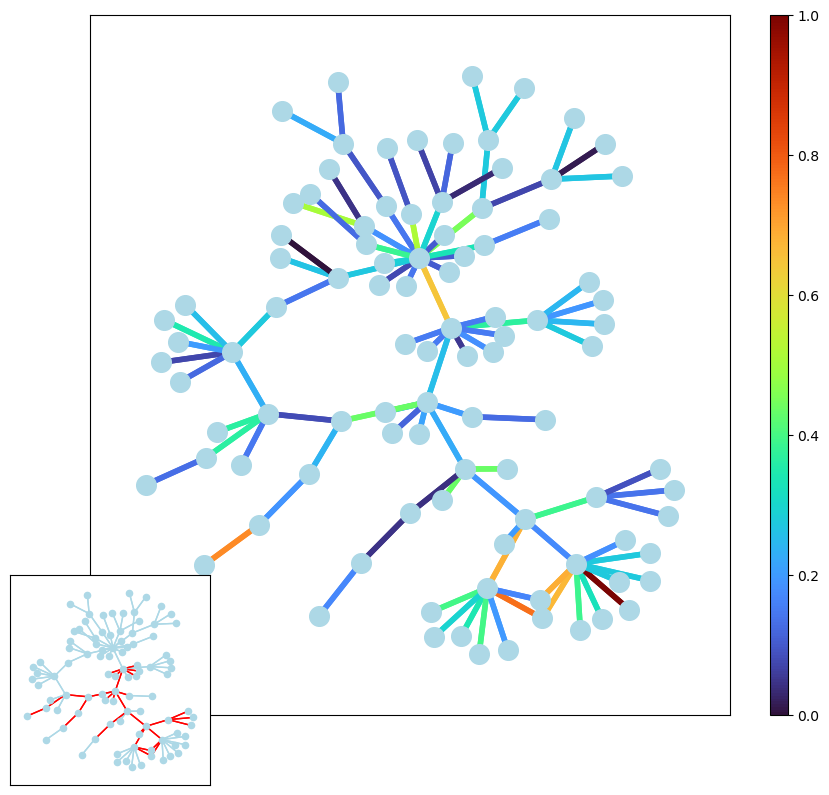

In [92]:
fig = plt.figure(figsize=(8, 7))

# Create the main plot axis
axs = fig.add_axes([0.1, 0.1, 1, 1])  # [left, bottom, width, height] in figure coordinates

G = nx.DiGraph()

edge_index = edge_indexes[g]
edge_gt = edges_gt[g]

# Add nodes
num_nodes = node_states[g].shape[1]
G.add_nodes_from(range(num_nodes))

# Add edges
edge_index = torch.cat(edge_index, dim=1)
edge_index = torch.unique(edge_index.T, dim=0).T
G.add_edges_from(edge_index.T.tolist())

# Plot the graph
pos = nx.kamada_kawai_layout(G)
cmap = matplotlib.colormaps.get_cmap('turbo')
norm = plt.Normalize(min(weights), max(weights))
nx.draw_networkx_nodes(G, pos, ax=axs,
                       node_color='lightblue', node_size=200)
pax = nx.draw_networkx_edges(G, pos, ax=axs,
                       arrows=False,
                       edge_color=norm(weights),
                       edge_cmap=cmap, edge_vmin=0, edge_vmax=1,
                       width=4)

plt.colorbar(pax, ax=axs, aspect=40)

# Create an inset axis within the first axis
inset_ax = fig.add_axes([0, 0, 0.25, 0.3])  # [left, bottom, width, height]

# Plot the ground truth
G_gt = nx.DiGraph()
G_gt.add_nodes_from(range(num_nodes))
G_gt.add_edges_from(edge_index.T.tolist())
nx.draw_networkx_nodes(G_gt, pos, ax=inset_ax, node_color='lightblue', node_size=20)
colors = ['r' if edge else 'lightblue' for edge in edge_gt.tolist()]
nx.draw_networkx_edges(G_gt, pos, ax=inset_ax,
                       arrows=False, 
                       edge_color=colors, width=1)

plt.show()